In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import genai_evaluation as ge
from genai_evaluation import multivariate_ecdf, ks_statistic
import nogan_synthesizer as ns
from nogan_synthesizer import NoGANSynth
from nogan_synthesizer.preprocessing import wrap_category_columns, unwrap_category_columns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.core.common.random_state(None)
seed = 1003
np.random.seed(seed)

In [2]:
#--- [1] read data, feature selection, remove missing values

url = "https://raw.githubusercontent.com/VincentGranville/Main/main/students.csv"
data = pd.read_csv(url)

data = data.drop(data[data["Curricular_units_2nd_sem_grade"] == 0].index)

features = [
  'Curricular_units_2nd_sem_approved',
  'Curricular_units_2nd_sem_grade',
  'Curricular_units_1st_sem_approved',
  'Curricular_units_1st_sem_grade',
  'Admission_grade',
  'Tuition_fees_up_to_date',
  'Curricular_units_2nd_sem_evaluations',
  'Age_at_enrollment',
  'Previous_qualification_grade',
  'Curricular_units_1st_sem_evaluations',
  'Course',
  'Father_occupation',
  'Mother_occupation',
  'Unemployment_rate',
  'GDP', 
  'Application_mode',
  'Father_qualification',
  'Curricular_units_2nd_sem_enrolled',
  'Mother_qualification',
  'Inflation_rate',
  'Target']

target_column = 'Target'

cat_cols = ['Course', 'Father_occupation', 'Mother_occupation', 
            'Unemployment_rate', 'GDP', 'Inflation_rate',
            'Application_mode', 'Father_qualification',
            'Mother_qualification', 'Tuition_fees_up_to_date', 'Target'
            ]

num_cols = [f for f in features if f not in cat_cols]

data = data[features]

In [3]:
#--- [2] Split real data into training and validation sets 

training_data = data.sample(frac = 0.5)
validation_data = data.drop(training_data.index)

In [4]:
#--- [3] Preprocess Categorical Columns

wrapped_train_data, idx_to_key_train, key_to_idx_train = \
                    wrap_category_columns(training_data,cat_cols)
                    
wrapped_val_data, idx_to_key_val, key_to_idx_val = \
                    wrap_category_columns(validation_data,cat_cols)

In [5]:
#--- [4] Train model

bin_values = [100] * len(wrapped_train_data.columns) 
nogan = NoGANSynth(wrapped_train_data,random_seed=seed)
nogan.fit(bins = bin_values)

In [6]:
#--- [5] Generate 3 synth. data: original NoGAN, Gaussian, Uniform

stretch_type_gaussian  = (["Gaussian"] * (len(wrapped_train_data.columns)-1)) + ["Uniform"]
stretch_nogan_orig  = [-1] * len(wrapped_train_data.columns)

print("Synth. NoGAN Original:")
wrapped_nogan_orig_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         stretch = stretch_nogan_orig
                                                         )
print("\nSynth. NoGAN Gaussian:")
wrapped_nogan_gauss_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         stretch_type= stretch_type_gaussian
                                                         )
print("\nSynth. NoGAN Uniform:")
wrapped_nogan_uniform_synth_data = nogan.generate_synthetic_data(len(wrapped_train_data),
                                                         debug = True ,
                                                         )
print()

Synth. NoGAN Original:
List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

Synth. NoGAN Gaussian:
List `stretch_type`: ['Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Synth. NoGAN Uniform:
List `stretch_type`: ['Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Uniform']
List `stretch`: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]



In [7]:
#--- [6] Evaluate using ECDF & KS Stat

_, ecdf_val1, ecdf_nogan_orig_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_orig_synth_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=seed)

_, ecdf_val2, ecdf_nogan_gauss_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_gauss_synth_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=seed)            

_, ecdf_val3, ecdf_nogan_uniform_synth = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_nogan_uniform_synth_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=seed)
            
_, ecdf_val4, ecdf_train = \
            multivariate_ecdf(wrapped_val_data, 
                              wrapped_train_data, 
                              n_nodes = 1000, 
                              verbose = True,
                              random_seed=seed)            
print()            
ks_stat_nogan_orig = ks_statistic(ecdf_val1, ecdf_nogan_orig_synth)
ks_stat_nogan_gauss = ks_statistic(ecdf_val2, ecdf_nogan_gauss_synth)
ks_stat_nogan_uniform = ks_statistic(ecdf_val3, ecdf_nogan_uniform_synth)
ks_stat_train = ks_statistic(ecdf_val4, ecdf_train)

print(f"KS Stat NoGAN Original(Synth vs Validation): {ks_stat_nogan_orig:.5f}")
print(f"KS Stat NoGAN Gauss (Synth vs Validation): {ks_stat_nogan_gauss:.5f}")
print(f"KS Stat NoGAN Uniform (Synth vs Validation): {ks_stat_nogan_uniform:.5f}")
print(f"Base KS Stat (Synth vs Train): {ks_stat_train:.5f}")

Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, location = 300
Sampling ecdf, location = 400
Sampling ecdf, location = 500
Sampling ecdf, location = 600
Sampling ecdf, location = 700
Sampling ecdf, location = 800
Sampling ecdf, location = 900
Sampling ecdf, location = 0
Sampling ecdf, location = 100
Sampling ecdf, location = 200
Sampling ecdf, loc

In [8]:
#--- [7] Expand Categorical Columns in Synth Data

nogan_orig_synth_data = unwrap_category_columns(data=wrapped_nogan_orig_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)
nogan_orig_synth_data = nogan_orig_synth_data[features]

nogan_gauss_synth_data = unwrap_category_columns(data=wrapped_nogan_gauss_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)
nogan_gauss_synth_data = nogan_gauss_synth_data[features]

nogan_uniform_synth_data = unwrap_category_columns(data=wrapped_nogan_uniform_synth_data,
                                                 idx_to_key=idx_to_key_train, cat_cols=cat_cols)
nogan_uniform_synth_data = nogan_uniform_synth_data[features]

In [9]:
%matplotlib inline

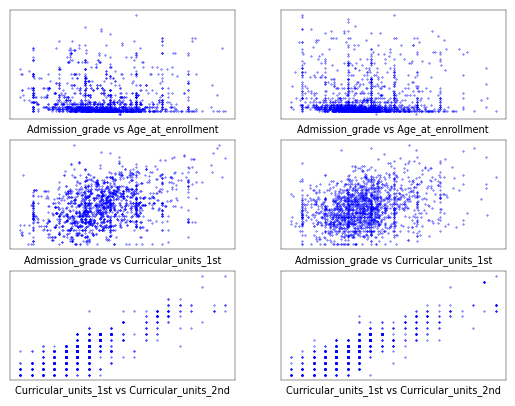

In [10]:
#--- [8] Evaluation scatterplots

dfs_orig = nogan_orig_synth_data
dfs_gauss = nogan_gauss_synth_data
dfs_uniform = nogan_uniform_synth_data
dfv = validation_data

def vg_scatter(df, feature1, feature2, counter, xlim, ylim):

    # customized plots, subplot position based on counter

    label = feature1[0:20] + " vs " + feature2[0:20]    
    df = df[(df[feature1] >= xlim[0]) & 
            (df[feature1] <= xlim[1]) &
            (df[feature2] >= ylim[0]) &
            (df[feature2] <= ylim[1])
           ]
    x = df[feature1].to_numpy()
    y = df[feature2].to_numpy()
    plt.subplot(3, 2, counter)
    plt.scatter(x, y, s = 0.1, c ="blue")
    plt.xlabel(label, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    return()

mpl.rcParams['axes.linewidth'] = 0.3

[col1, col2] = [features[4], features[7]]
xlim = [min(dfv[col1]), max(dfv[col1])]
ylim = [min(dfv[col2]), max(dfv[col2])]
vg_scatter(dfs_uniform, col1, col2, 1, xlim, ylim)
vg_scatter(dfv, col1, col2, 2, xlim, ylim)

[col1, col2] = [features[4], features[3]]
xlim = [min(dfv[col1]), max(dfv[col1])]
ylim = [10, max(dfv[features[3]])]
vg_scatter(dfs_uniform, features[4], features[3], 3, xlim, ylim)
vg_scatter(dfv, features[4], features[3], 4, xlim, ylim)

[col1, col2] = [features[2], features[0]]
xlim = [min(dfv[features[2]]), max(dfv[features[0]])]
ylim = [min(dfv[features[2]]), max(dfv[features[0]])]
vg_scatter(dfs_uniform, features[2], features[0], 5, xlim, ylim)
vg_scatter(dfv, features[2], features[0], 6, xlim, ylim)

plt.show()